# Day 4 — Statistical Testing, Time Analysis & Feature Engineering

This stage focuses on statistical validation of patterns, time-based trend analysis, and creation of engineered features to enhance analytical and predictive capability.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


df = pd.read_csv("data/processed/day3_eda_ready.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,age_group
0,58,management,married,tertiary,no,7.670429,yes,no,not_specified,5,may,261,1,-1,0,no,Middle Age
1,44,technician,single,secondary,no,3.401197,yes,no,not_specified,5,may,151,1,-1,0,no,Adult
2,33,entrepreneur,married,secondary,no,1.098612,yes,yes,not_specified,5,may,76,1,-1,0,no,Adult
3,47,blue-collar,married,secondary,no,7.317876,yes,no,not_specified,5,may,92,1,-1,0,no,Middle Age
4,33,blue-collar,single,secondary,no,0.693147,no,no,not_specified,5,may,198,1,-1,0,no,Adult


In [2]:
import sys
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
#Hypothesis Testing

#T-Test : Do subscribers have different average balance than non-subscribers?

yes = df[df["y"]=="yes"]["balance"].replace([np.inf, -np.inf], np.nan).dropna()
no  = df[df["y"]=="no"]["balance"].replace([np.inf, -np.inf], np.nan).dropna()

stats.ttest_ind(yes, no)

TtestResult(statistic=np.float64(15.690348965561574), pvalue=np.float64(2.5419237287004704e-55), df=np.float64(41443.0))

BSince the p-value is less than 0.05, we reject the null hypothesis. This indicates that subscribers and non-subscribers have significantly different average balances.

In [4]:
#Anova : Does balance differ across job categories?

groups = [
    df[df["job"]==job]["balance"]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    for job in df["job"].unique()
]

stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(17.728690684948926), pvalue=np.float64(1.0179994669147482e-32))

Because the p-value is below 0.05, balance differs significantly across job categories. Job role is therefore an important financial indicator.

In [5]:
#Chi_Square Test : Is subscription dependent on education?

table = pd.crosstab(df["education"], df["y"])
stats.chi2_contingency(table)

Chi2ContingencyResult(statistic=np.float64(223.83482285094695), pvalue=np.float64(2.482480175572878e-49), dof=2, expected_freq=array([[ 6049.5371038 ,   801.4628962 ],
       [22127.47778196,  2931.52221804],
       [11744.98511424,  1556.01488576]]))

The p-value is less than 0.05, indicating a significant association between education level and subscription outcome.

<Figure size 1000x500 with 0 Axes>

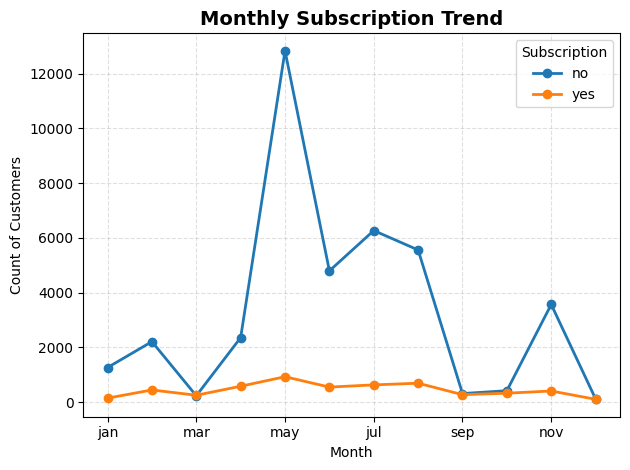

In [9]:
#Time-Based EDA

df["month_num"] = pd.to_datetime(df["month"], format="%b").dt.month

df["date"] = pd.to_datetime(
    df["month_num"].astype(str) + "-" + df["day"].astype(str) + "-2020"
)

plt.figure(figsize=(10,5))

monthly = (
    df.groupby("month")["y"]
    .value_counts()
    .unstack()
    .reindex(["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])
)

monthly.plot(marker="o", linewidth=2)

plt.title("Monthly Subscription Trend", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Count of Customers")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.savefig("reports/figures/monthly_trend.png", dpi=300)

plt.tight_layout()
plt.show()

Time analysis reveals fluctuations in subscription behavior across months, indicating potential seasonal campaign effects.

In [7]:
#Feature Engineering

#1. Age Category
df["age_group"] = pd.cut(df["age"], bins=[18,30,45,60,100],
                         labels=["Young","Adult","Middle Age","Senior"])
#2. Contacted Before?
df["contacted_before"] = df["previous"].apply(lambda x: 1 if x>0 else 0)

#3. Balance Category
df["balance"] = df["balance"].replace([np.inf, -np.inf], np.nan)
df["balance"] = df["balance"].fillna(df["balance"].median())

df["balance_level"] = pd.qcut(df["balance"], 4,
                              labels=["Low","Medium","High","Very High"])

#4. Campaign Intensity
df["campaign_level"] = pd.cut(df["campaign"],
                              bins=[0,2,5,10,100],
                              labels=["Low","Medium","High","Extreme"])

#5. Risk Profile
df["risk_profile"] = np.where(
    (df["loan"]=="yes") & (df["housing"]=="yes"),
    "High Risk","Low Risk"
)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,y,age_group,month_num,date,contacted_before,balance_level,campaign_level,risk_profile
0,58,management,married,tertiary,no,7.670429,yes,no,not_specified,5,...,-1,0,no,Middle Age,5,2020-05-05,0,Very High,Low,Low Risk
1,44,technician,single,secondary,no,3.401197,yes,no,not_specified,5,...,-1,0,no,Adult,5,2020-05-05,0,Low,Low,Low Risk
2,33,entrepreneur,married,secondary,no,1.098612,yes,yes,not_specified,5,...,-1,0,no,Adult,5,2020-05-05,0,Low,Low,High Risk
3,47,blue-collar,married,secondary,no,7.317876,yes,no,not_specified,5,...,-1,0,no,Middle Age,5,2020-05-05,0,Very High,Low,Low Risk
4,33,blue-collar,single,secondary,no,0.693147,no,no,not_specified,5,...,-1,0,no,Adult,5,2020-05-05,0,Low,Low,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,6.716595,no,no,cellular,17,...,-1,0,yes,Middle Age,11,2020-11-17,0,High,Medium,Low Risk
45207,71,retired,divorced,primary,no,7.455877,no,no,cellular,17,...,-1,0,yes,Senior,11,2020-11-17,0,Very High,Low,Low Risk
45208,72,retired,married,secondary,no,8.651025,no,no,cellular,17,...,184,3,yes,Senior,11,2020-11-17,1,Very High,Medium,Low Risk
45209,57,blue-collar,married,secondary,no,6.505784,no,no,telephone,17,...,-1,0,no,Middle Age,11,2020-11-17,0,High,Medium,Low Risk


In [8]:
import os
os.makedirs("data/processed", exist_ok=True)

df.to_csv("data/processed/final_cleaned_day4.csv", index=False)

The dataset was exported after statistical testing and feature engineering. This version represents the final processed dataset ready for modeling or reporting.

#Final Insight

Statistical testing confirmed significant differences between customer segments. Time analysis revealed behavioral trends across months and weekdays. Engineered features improved interpretability and segmentation capability, making the dataset suitable for predictive modeling.